Check mydrive content:

Which GPU Am I Using?

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()#helps plotting the dates easier!
sns.set(style='darkgrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 10, 8

In [ ]:
df_org = pd.read_csv('/content/drive/My Drive/Colab dataset/DOGE_USD_historical.csv')
print('Shape:', df_org.shape)
print('Header:')
#print(df_org.head())
df_org

Shape: (2424, 7)
Header:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1.463600e+06
1,2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2.215910e+06
2,2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,8.835630e+05
3,2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,9.930040e+05
4,2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,5.391400e+05
...,...,...,...,...,...,...,...
2419,2021-05-02,0.391087,0.400029,0.364874,0.376046,0.376046,8.040407e+09
2420,2021-05-03,0.373631,0.445567,0.373631,0.441707,0.441707,1.052665e+10
2421,2021-05-04,0.440274,0.605998,0.400800,0.541334,0.541334,3.823813e+10
2422,2021-05-05,0.537355,0.695262,0.523822,0.657633,0.657633,4.252510e+10


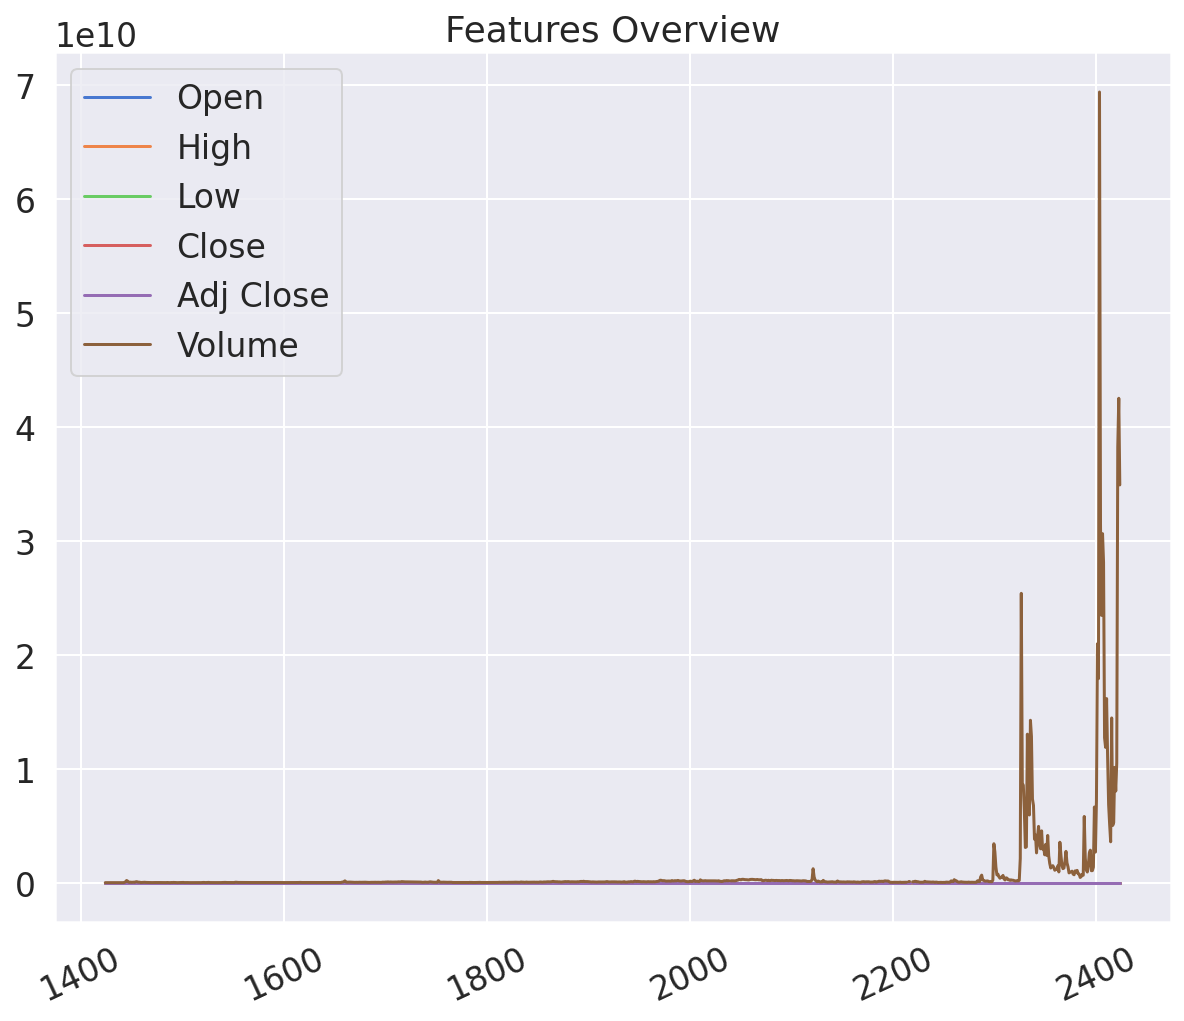

In [ ]:
df_for_plot = df_org.tail(1000) #This function returns last n rows from the object based on position. It is useful for quickly verifying data, for example, after sorting or appending rows.
df_for_plot.plot.line()
plt.title('Features Overview')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
# check for nul, nan, 0
df_org.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
dtype: bool

In [ ]:
df_org = df_org.dropna()
df_org.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Time Series Volume Over time')

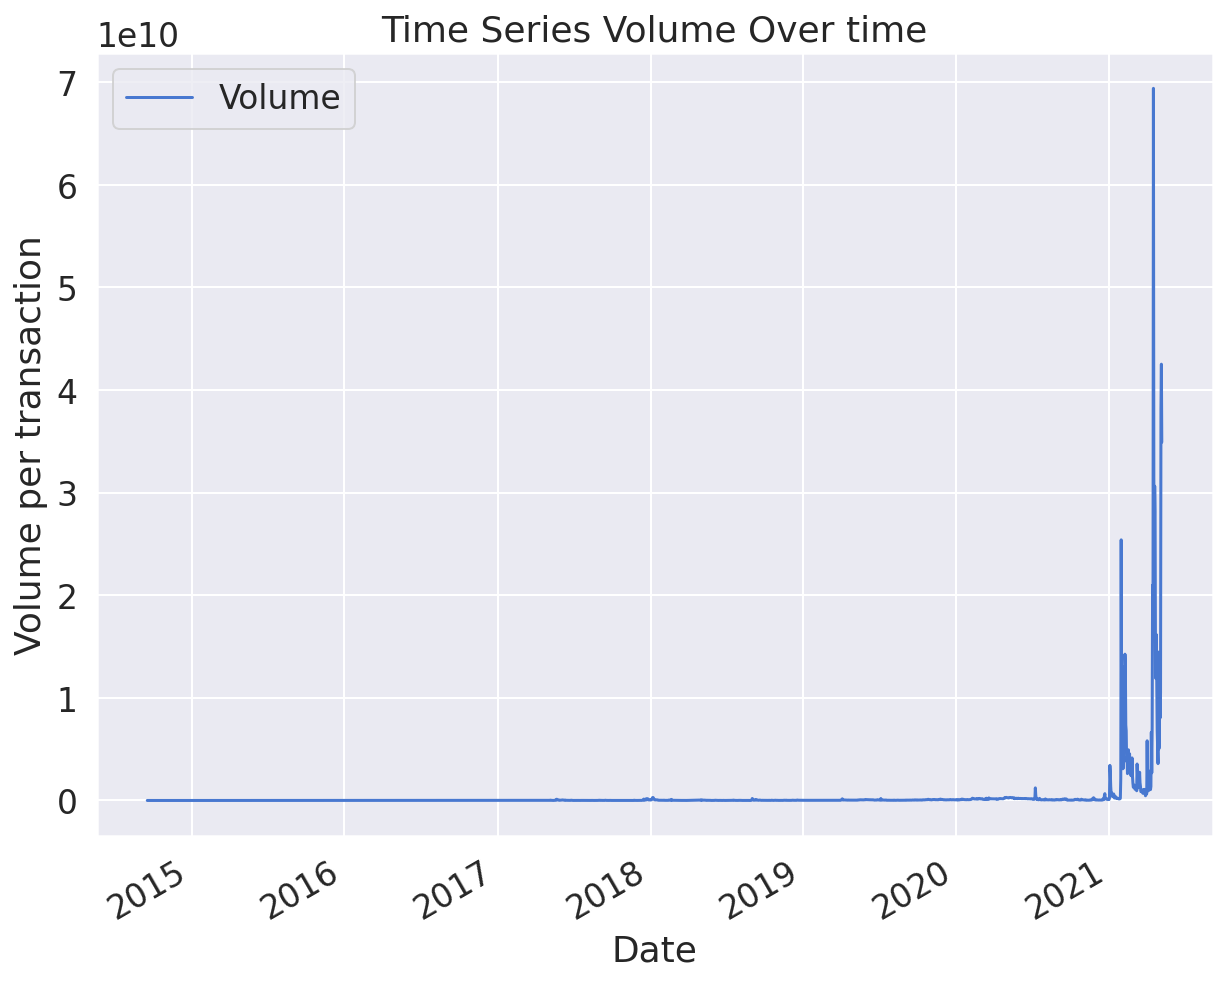

In [ ]:
# creating data frame and indexing
df = df_org[['Date', 'Volume']]
df['Date'] = pd.to_datetime(df['Date'])

# plotting date against volume
df.plot(x='Date', y='Volume')
plt.xlabel('Date')
plt.ylabel('Volume per transaction')
plt.title('Time Series Volume Over time')

# Preprcessing
## Splitting
90% for training
10% for testing

In [ ]:
# training = 90% , test = 10% of len(df1)
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2178, 2) (242, 2)


## Scaling
LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used as activation functions. rescale the data to the range of 0-to-1, also called normalizing.

In [ ]:
train

,Date,Volume
0,2014-09-17,1463600.0
1,2014-09-18,2215910.0
2,2014-09-19,883563.0
3,2014-09-20,993004.0
4,2014-09-21,539140.0
...,...,...
2174,2020-08-30,79325829.0
2175,2020-08-31,85369757.0
2176,2020-09-01,81863764.0
2177,2020-09-02,56647412.0


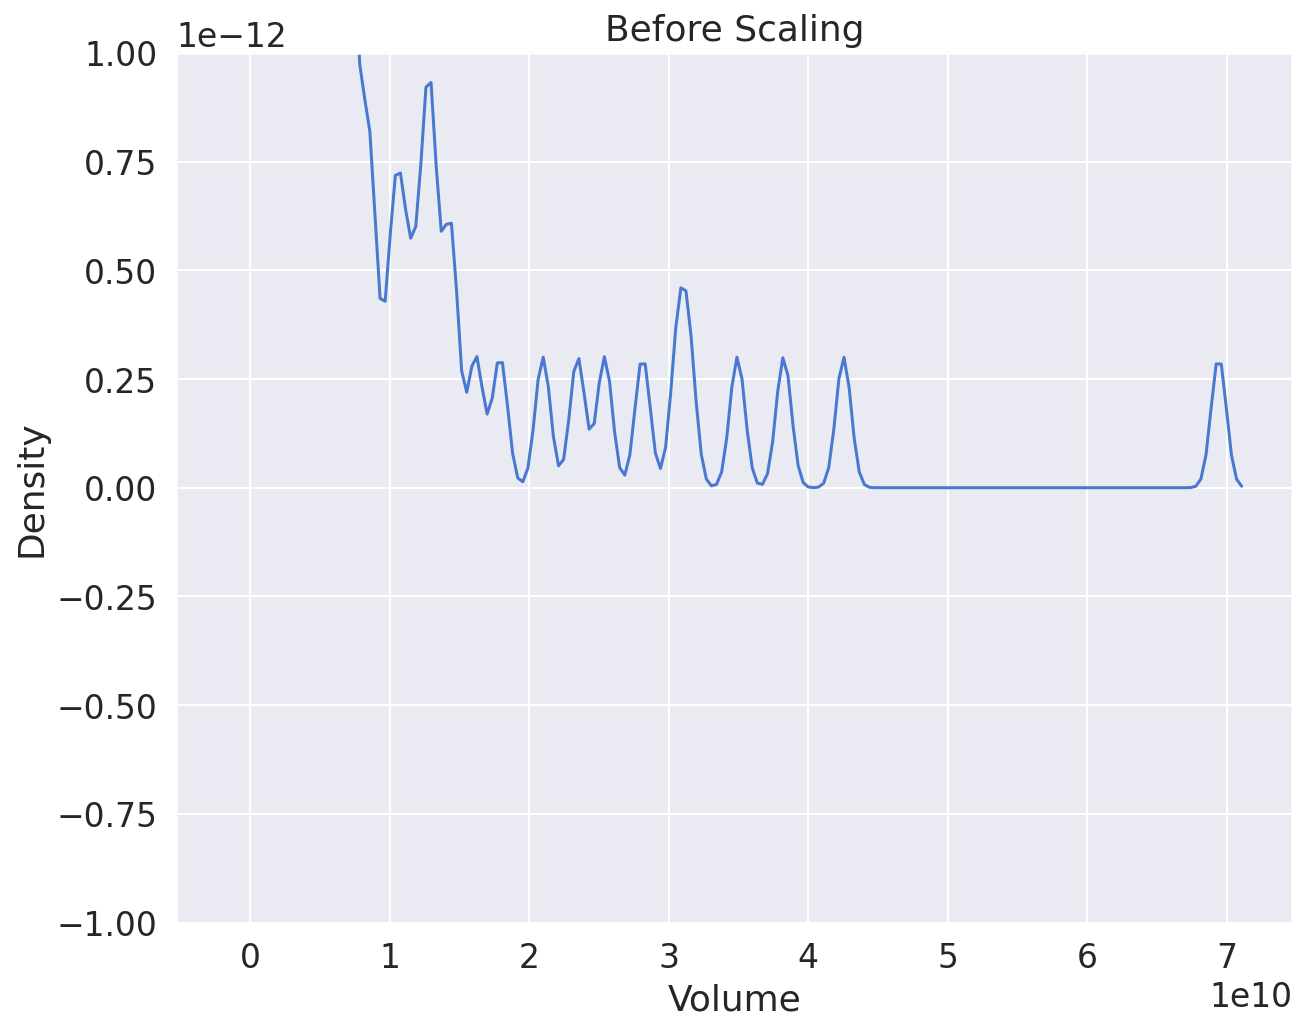

In [ ]:
fig, (ax1) = plt.subplots()#ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['Volume'], ax=ax1)

In [ ]:
# Standardize features by removing the MEAN and scaling to UNIT VARIANCE!
scaler = StandardScaler() 
scaler = scaler.fit(train[['Volume']])

train['Volume'] = scaler.transform(train[['Volume']])
test['Volume'] = scaler.transform(test[['Volume']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train['Volume']

0      -0.481223
1      -0.468562
2      -0.490984
3      -0.489143
4      -0.496781
          ...   
2174    0.829145
2175    0.930860
2176    0.871856
2177    0.447483
2178    0.502298
Name: Volume, Length: 2178, dtype: float64

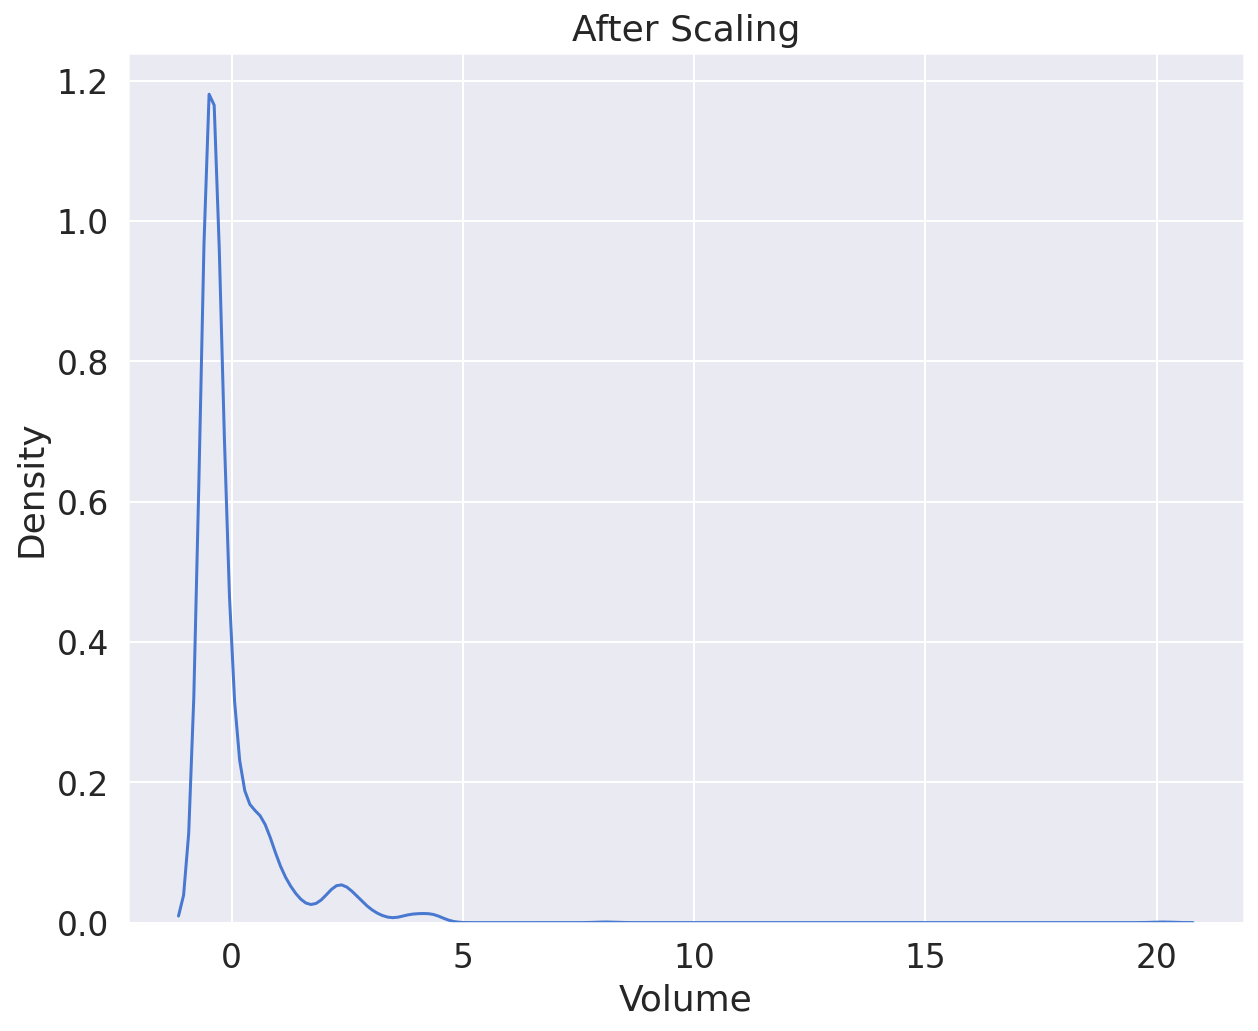

In [ ]:
fig, (ax1) = plt.subplots()#ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(train['Volume'], ax=ax1)

In [ ]:
print(train.shape)
print(test.shape)

(2178, 2)
(242, 2)


### Helper Function to Creat Proper Shape Data
hen we reshape our data into a format suitable for input into an LSTM network. LSTM cells expect a 3 dimensional tensor of the form [data samples, time steps, features]. Here, each sample input into the LSTM network represents one step in time and contains 1 feature — the volume of coins!.

In [ ]:
sequence = 30  # Number of time steps to look back 
# Xs are our sequence = 30, Y is what comes after the sequence = 1

def to_sequences(x, y, sequence=1):
    x_vals = []
    y_vals = []
    for i in range(len(x)-sequence):
        #print(i)
        x_vals.append(x.iloc[i:(i+sequence)].values)
        y_vals.append(y.iloc[i+sequence])   
    return np.array(x_vals), np.array(y_vals)

trainX, trainY = to_sequences(train[['Volume']], train['Volume'], sequence)
testX, testY = to_sequences(test[['Volume']], test['Volume'], sequence)

In [ ]:
print(trainX.shape)
print(testX.shape)
# first 30 samples are reserved!

(2148, 30, 1)
(212, 30, 1)


# LSTM Autoencoder
Autoencoder should take a sequence as input and outputs a sequence of the same shape.

In [ ]:
#LSTM Autoencoder Configs 04
model = keras.Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2)) # applying regularization To reduce overfitting

model.add(RepeatVector(trainX.shape[1]))# to shape input for TimeDistributed

model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

model.add(TimeDistributed(Dense(trainX.shape[2]))) #applies a layer to every temporal slice of an input to
# creates a vector with a length of the number of outputs from the previous layer

model.compile(optimizer='adam', loss='mae')
# model.summary()


# fitting the model
history = model.fit(
    trainX, trainY,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
31/31 [==============================] - 5s 54ms/step - loss: 0.2132 - val_loss: 1.3339
Epoch 2/10
31/31 [==============================] - 1s 30ms/step - loss: 0.1178 - val_loss: 1.0768
Epoch 3/10
31/31 [==============================] - 1s 30ms/step - loss: 0.1085 - val_loss: 1.1145
Epoch 4/10
31/31 [==============================] - 1s 30ms/step - loss: 0.1024 - val_loss: 1.0222
Epoch 5/10
31/31 [==============================] - 1s 29ms/step - loss: 0.0983 - val_loss: 1.0821
Epoch 6/10
31/31 [==============================] - 1s 29ms/step - loss: 0.0935 - val_loss: 1.0565
Epoch 7/10
31/31 [==============================] - 1s 29ms/step - loss: 0.0919 - val_loss: 0.9540
Epoch 8/10
31/31 [==============================] - 1s 30ms/step - loss: 0.0880 - val_loss: 0.9685
Epoch 9/10
31/31 [==============================] - 1s 29ms/step - loss: 0.0841 - val_loss: 0.9627
Epoch 10/10
31/31 [==============================] - 1s 29ms/step - loss: 0.0827 - val_loss: 0.9740


The RepeatVector layer simply repeats the input n times.
return_sequences=True in LSTM layer makes it return the sequence.
TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer.

Note: ‘None’ is the batch number. In our case batch_size = 64!

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_15 (ModuleWra (None, 32)                4352      
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 32)                0         
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 30, 32)            0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 30, 32)            8320      
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 30, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Loss Error')

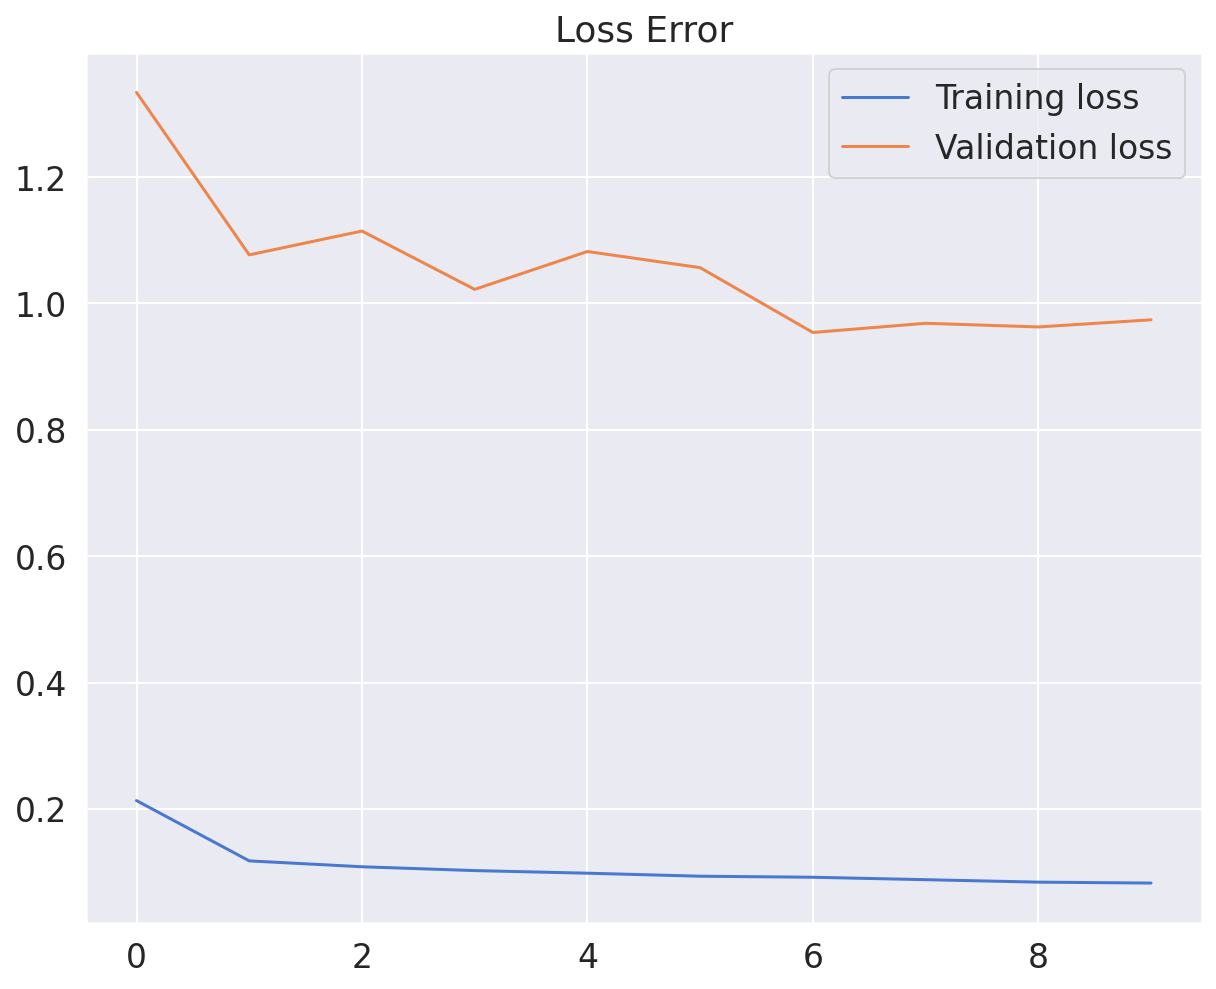

In [ ]:
# plotting training loss and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss Error')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Training Erorr')

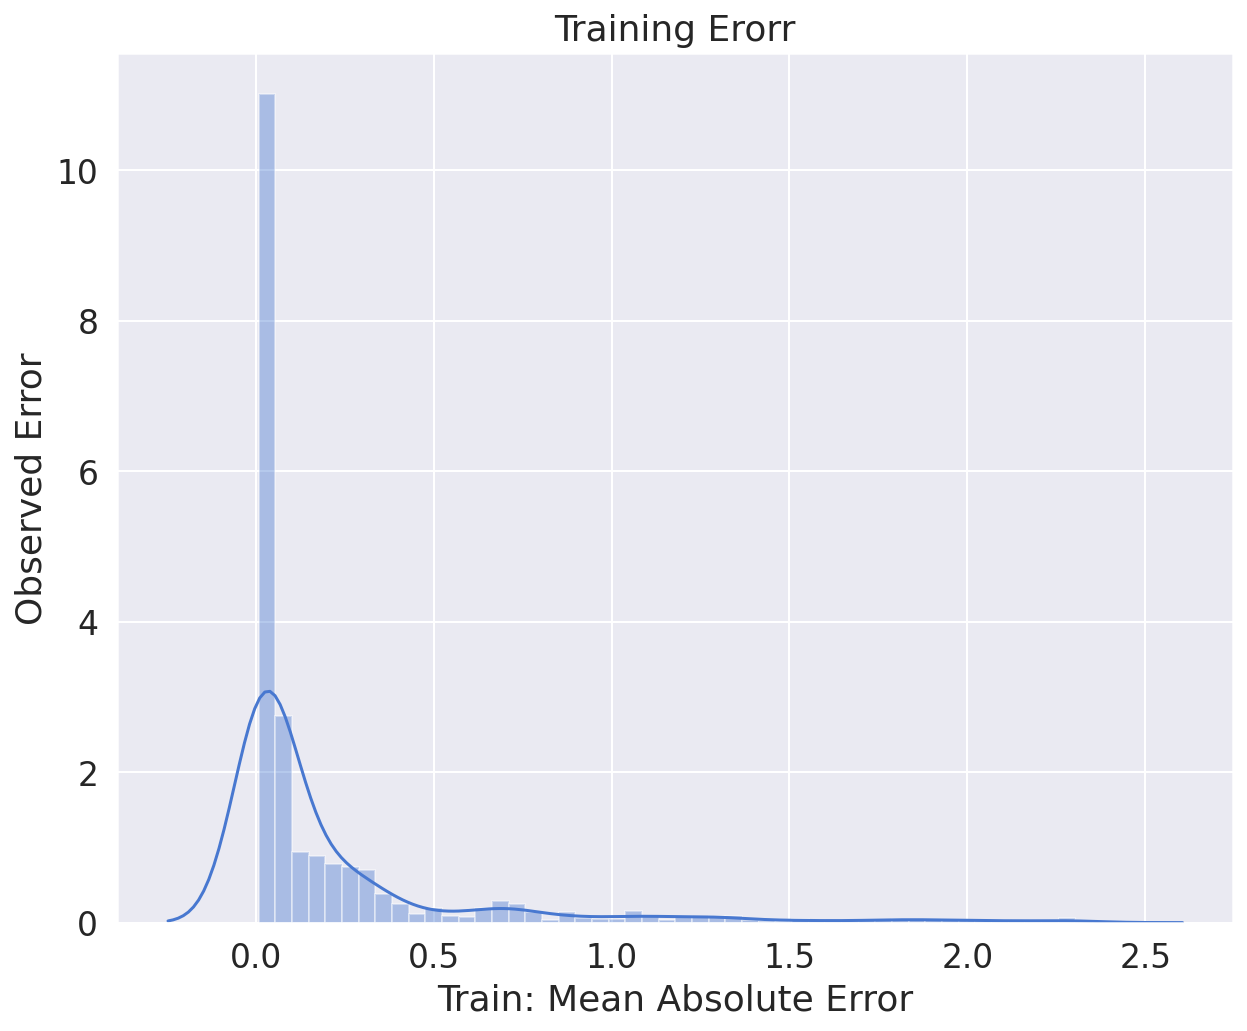

In [ ]:
# Plotting the train prediction error
# Anologous to Z-test!
train_pred = model.predict(trainX)
train_MAE = np.mean(np.abs(train_pred - trainX), axis=1)
sns.distplot(train_MAE, bins=50, kde=True, axlabel='Train: Mean Absolute Error');

plt.ylabel('Observed Error')
plt.title('Training Erorr')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Testing Error')

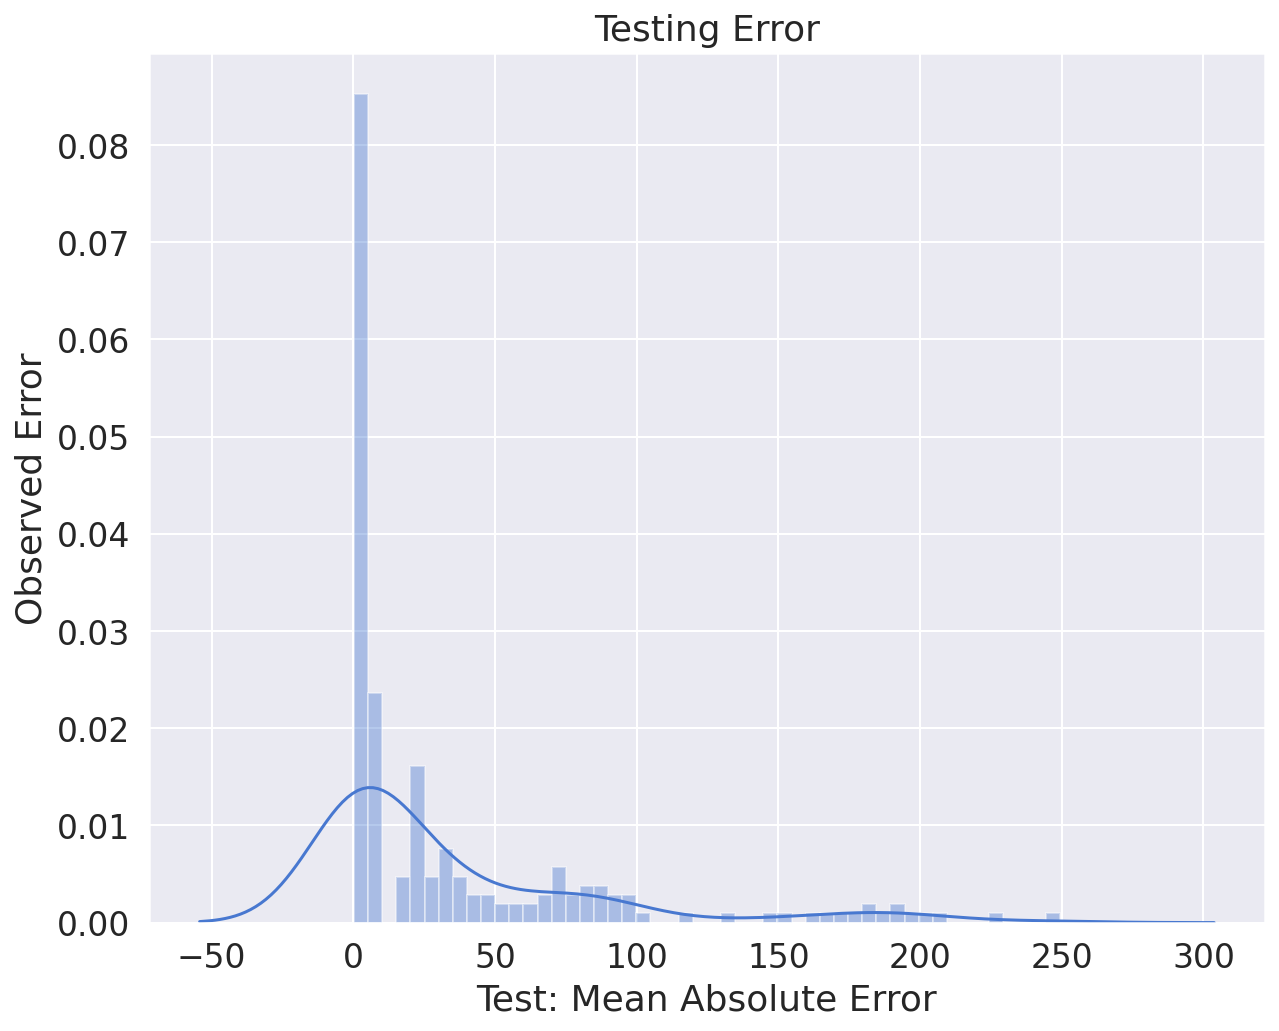

In [ ]:
# Recunstruction error = MeanAbsoluteError in this case!
test_pred = model.predict(testX) # y_hat
test_MAE = np.mean(np.abs(test_pred - testX), axis=1)
sns.distplot(test_MAE, bins=50, kde=True, axlabel='Test: Mean Absolute Error');


plt.ylabel('Observed Error')
plt.title('Testing Error')

In [ ]:
max_train_MAE = 50  # Threshold/max of reconstruction error!

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[sequence:])
anomaly_df['test_MAE'] = test_MAE
anomaly_df['max_train_MAE'] = max_train_MAE
anomaly_df['Anomaly'] = anomaly_df['test_MAE'] > anomaly_df['max_train_MAE']
anomaly_df['Volume'] = test[sequence:]['Volume']

In [ ]:
anomaly_df

,Date,Volume,test_MAE,max_train_MAE,Anomaly
2209,2020-10-04,0.018811,0.819912,50,False
2210,2020-10-05,-0.023012,0.820921,50,False
2211,2020-10-06,0.031882,0.823608,50,False
2212,2020-10-07,0.222166,0.791851,50,False
2213,2020-10-08,0.233927,0.724474,50,False
...,...,...,...,...,...
2419,2021-05-02,134.808626,196.789559,50,True
2420,2021-05-03,176.650375,200.076025,50,True
2421,2021-05-04,643.015330,205.355531,50,True
2422,2021-05-05,715.162102,226.298928,50,True


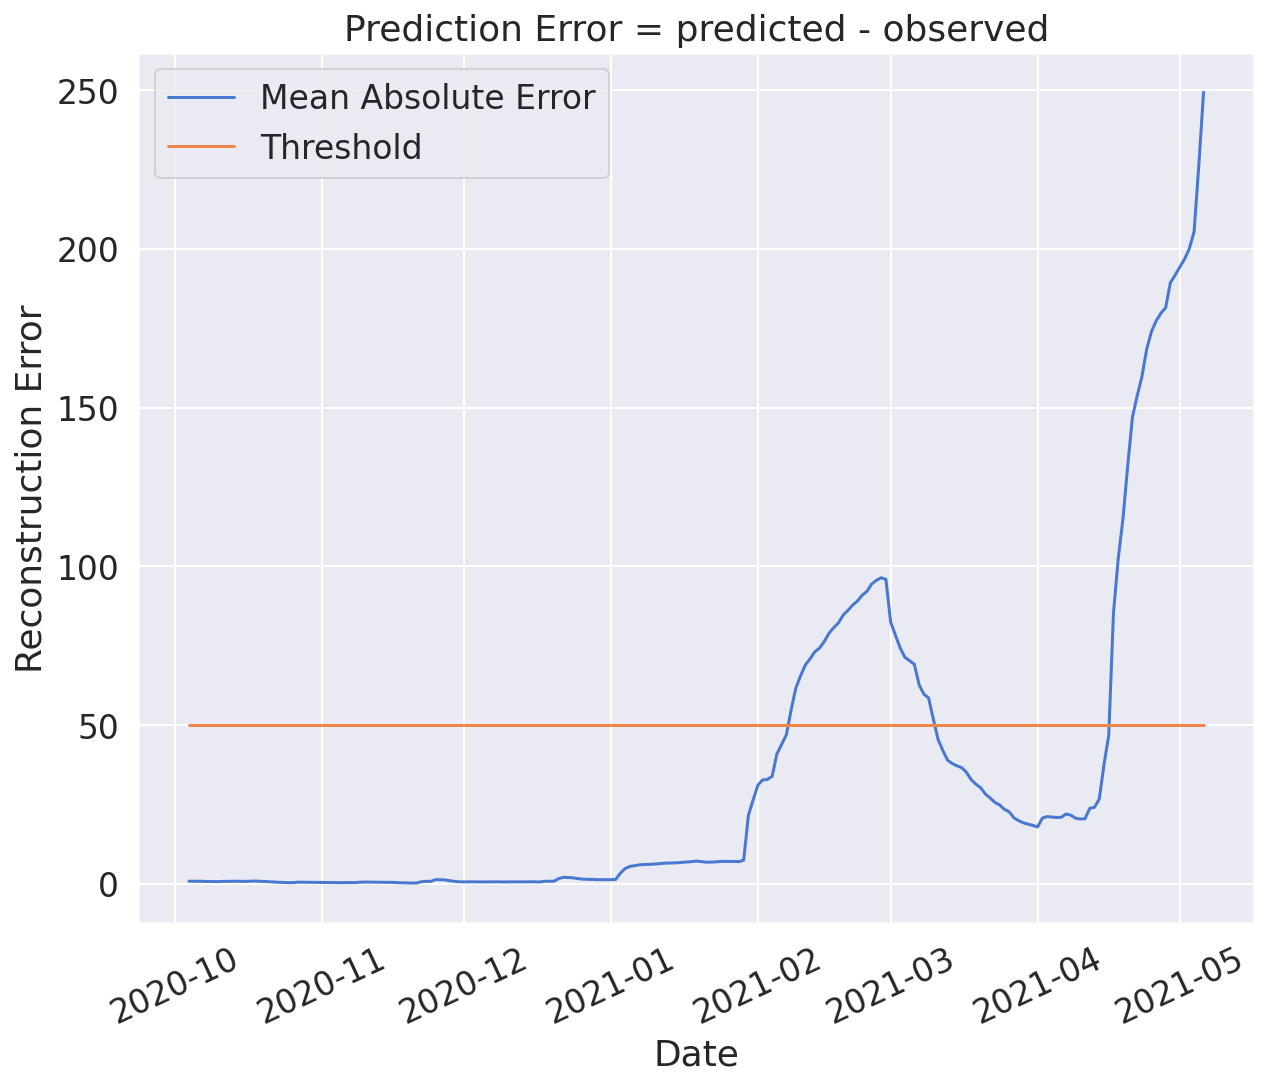

In [ ]:
#Plot test_MAE vs max_train_MAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['test_MAE'], label='Mean Absolute Error')
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_train_MAE'], label='Threshold')

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Prediction Error = predicted - observed')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['Anomaly'] == True]
anomalies.head(10)

,Date,Volume,test_MAE,max_train_MAE,Anomaly
2336,2021-02-08,215.656086,54.736348,50,True
2337,2021-02-09,123.170048,61.668276,50,True
2338,2021-02-10,113.682485,65.518946,50,True
2339,2021-02-11,63.757811,68.962830,50,True
2340,2021-02-12,70.023145,70.867265,50,True
2341,2021-02-13,43.554110,73.092250,50,True
2342,2021-02-14,66.553343,74.263553,50,True
2343,2021-02-15,82.711789,76.320665,50,True
2344,2021-02-16,56.873311,78.967719,50,True
2345,2021-02-17,49.580668,80.689896,50,True


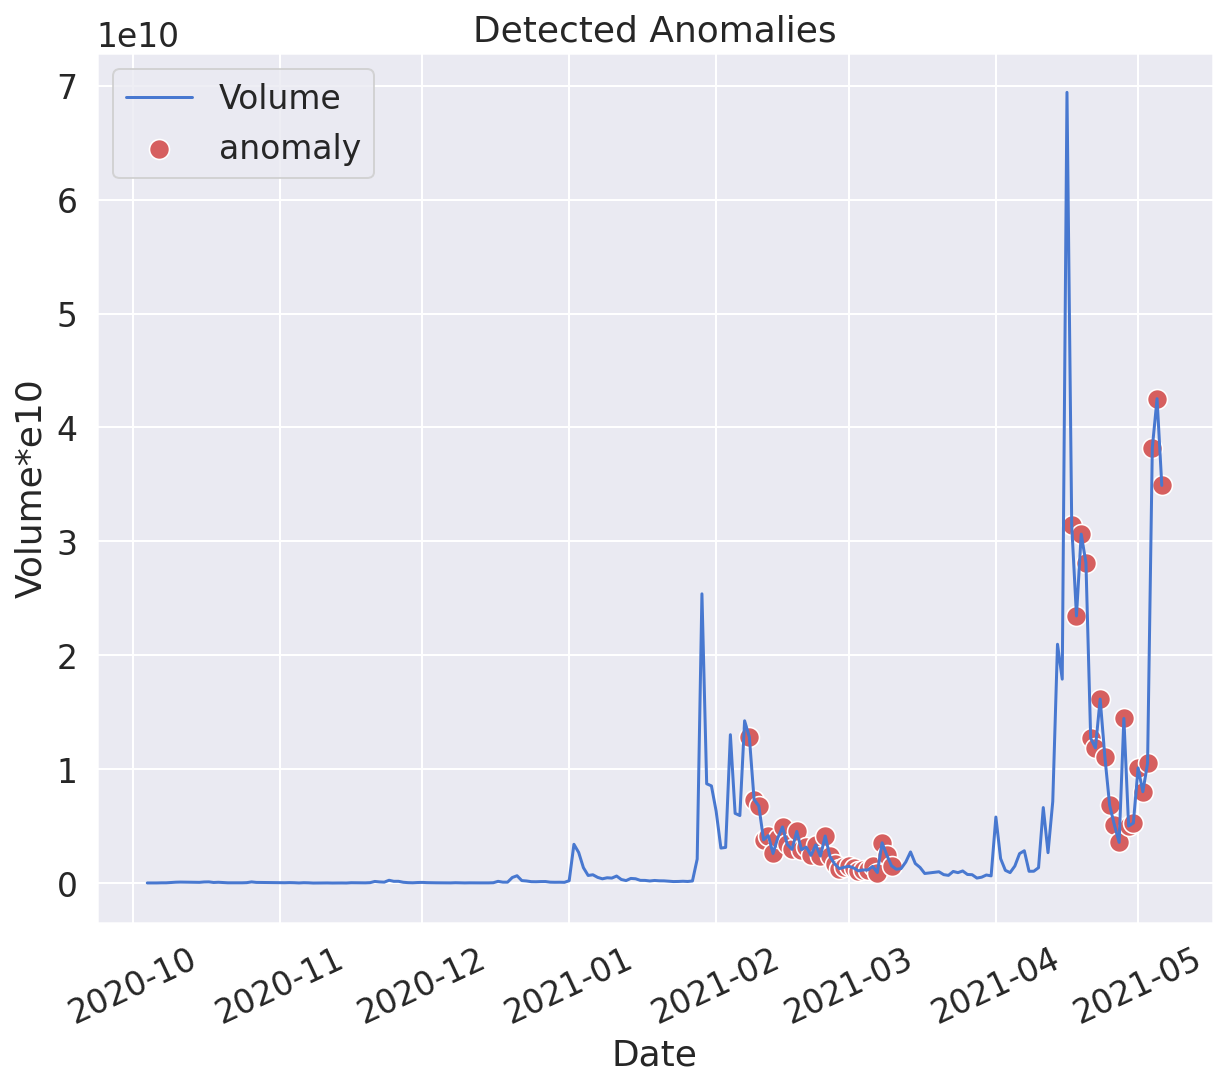

In [ ]:
#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Volume']), label='Volume')
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Volume']), color='r', s=100, label='anomaly')

plt.xlabel('Date')
plt.ylabel('Volume*e10')
plt.title('Detected Anomalies')
plt.xticks(rotation=25)
plt.legend();